In [1]:
# use extension to auto reload modules
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

In [2]:
import logging
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from simple_scraper import EcoCounterScraper
import meteostat

In [3]:
log = logging.getLogger('EcoCounterScraper')
log.setLevel(logging.DEBUG)
if not log.hasHandlers():
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    log.addHandler(ch)

In [4]:
cagnes_scrapper = EcoCounterScraper(site_id="300037212")
paris_sebastopol_scrapper = EcoCounterScraper(site_id="100158705")
nice_carras_scrapper = EcoCounterScraper(site_id="300019544")

bike_scrapper = cagnes_scrapper

In [5]:
bike_scrapper

EcoCounterScraper(site_id=300037212)
  [Not yet initialized]

In [6]:
bike_scrapper.fetch_counts()

2025-12-03 21:50:44,428 - EcoCounterScraper.site_300037212 - DEBUG - Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&startDate=2025-12-02&endDate=2025-12-03


2025-12-03 21:50:44,831 - EcoCounterScraper.site_300037212 - DEBUG - Downloaded 578688 bytes
2025-12-03 21:50:44,834 - EcoCounterScraper.site_300037212 - DEBUG - Extracting data...
2025-12-03 21:50:44,835 - EcoCounterScraper.site_300037212 - DEBUG - Parsing HTML to extract embedded count data...
2025-12-03 21:50:44,864 - EcoCounterScraper.site_300037212 - DEBUG - Transforming global counts to DataFrame.
2025-12-03 21:50:44,868 - EcoCounterScraper.site_300037212 - DEBUG - Transforming directional counts to DataFrame.


,count,in,out
timestamp,,,
2025-12-02,2431,1223,1208


In [7]:
bike_scrapper

EcoCounterScraper(site_id=300037212)
  Site name: Cagnes sur Mer (FR)
  Location: {'lat': 43.657754, 'lon': 7.168889}
  First data date: 2019-01-01

In [8]:
counter_location = meteostat.Point(**bike_scrapper.site_location_)

In [9]:
data_bike = bike_scrapper.fetch_all_counts()
start = data_bike.index[0]
end = data_bike.index[-1]
data_weather = meteostat.Daily(counter_location, start, end).fetch()
data_counter = pd.concat([data_weather, data_bike], axis=1)

2025-12-03 21:50:45,028 - EcoCounterScraper.site_300037212 - DEBUG - Requested period longer than 1 year with daily frequency. Splitting requests...
2025-12-03 21:50:45,030 - EcoCounterScraper.site_300037212 - DEBUG - Fetch data from 2019-01-01 to 2019-12-31...


2025-12-03 21:50:45,032 - EcoCounterScraper.site_300037212 - DEBUG - Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&startDate=2019-01-01&endDate=2019-12-31
2025-12-03 21:50:45,353 - EcoCounterScraper.site_300037212 - DEBUG - Downloaded 578309 bytes
2025-12-03 21:50:45,354 - EcoCounterScraper.site_300037212 - DEBUG - Extracting data...
2025-12-03 21:50:45,355 - EcoCounterScraper.site_300037212 - DEBUG - Parsing HTML to extract embedded count data...
2025-12-03 21:50:45,371 - EcoCounterScraper.site_300037212 - DEBUG - Transforming global counts to DataFrame.
2025-12-03 21:50:45,377 - EcoCounterScraper.site_300037212 - DEBUG - Transforming directional counts to DataFrame.
2025-12-03 21:50:45,384 - EcoCounterScraper.site_300037212 - DEBUG - Fetch data from 2020-01-01 to 2020-12-30...
2025-12-03 21:50:45,386 - EcoCounterScraper.site_300037212 - DEBUG - Fetching data from: https://eco-display-map.eco-counter.com/site/300037212?granularity=P1D&start

In [10]:
data_counter['is_weekend'] = data_counter.index.dayofweek >= 5
data_counter['weekday'] = data_counter.index.day_name()
data_counter['is_rainy'] = data_counter['prcp'] > 1.

In [11]:
data_counter = data_counter.drop(columns=['snow', 'wdir', 'tsun'])

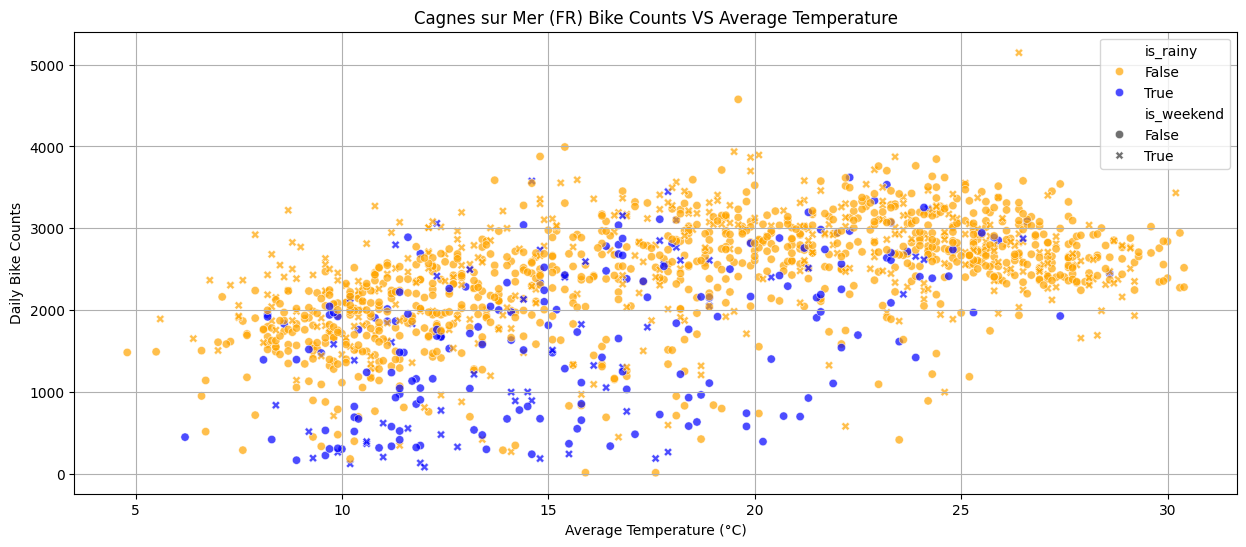

In [12]:
plt.figure(figsize=(15, 6))
sns.scatterplot(
    data=data_counter.dropna(), 
    x='tavg', 
    y='count', 
    hue='is_rainy', 
    palette={True: 'blue', False: 'orange'},
    alpha=0.7,
    style='is_weekend',
)
plt.title(f'{bike_scrapper.site_name_} Bike Counts VS Average Temperature')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Daily Bike Counts')
plt.grid(which='both')
